In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import cPickle as pickle
from string import punctuation
from nltk import word_tokenize
from nltk.stem import snowball
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import PunktSentenceTokenizer
import time
import seaborn as sb
%matplotlib inline


stemmer = snowball.SnowballStemmer("english")

In [2]:
def load_data(filename):
    '''
    Load data into a data frame for use in running model
    '''
    return pickle.load(open(filename, 'rb'))


def stem_tokens(tokens, stemmer):
    '''Stem the tokens.'''
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def OHStokenize(text):
    '''Tokenize & stem. Stems automatically for now.
    Leaving "stemmer" out of function call, so it works with TfidfVectorizer'''
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [3]:
fscorepath = '../../data/f1_score_dataframe.csv'
resultspath = '../../data/twitter_cross_val_xgboost_results.csv'

In [4]:
vect = pickle.load(open('../../xgb_models/xgbfinal4/vect.p', 'rb'))

/home/mgupta/anaconda2/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version pre-0.18 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/mgupta/anaconda2/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version pre-0.18 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
vocab = vect.get_feature_names()

In [6]:
vocab[273851]

u'fat'

In [7]:
dfscore = pd.read_csv(fscorepath)
dresults = pd.read_csv(resultspath)

/home/mgupta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


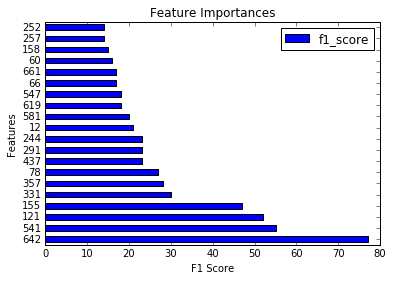

In [8]:
dfscore = dfscore.sort('f1_score',ascending=False)
dfscore[:20].plot(kind='barh')
plt.xlabel("F1 Score")
plt.ylabel("Features")
plt.title("Feature Importances")

In [20]:
dfscore[:10]

,Unnamed: 0,f1_score
642,f273851,77
541,f27584,55
121,f24667,52
155,f287435,47
331,f516816,30
357,f369474,28
78,f284867,27
244,f374639,23
291,f513901,23
437,f290982,23


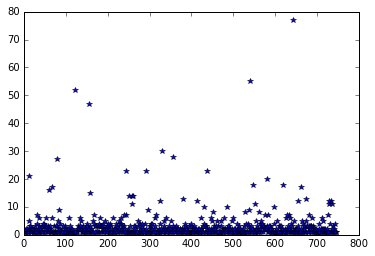

In [10]:
plt.plot(dfscore['f1_score'],'*')

In [10]:
vals = []
features = []
numfeatures = 10
df = dfscore[:numfeatures]
df.reset_index(inplace=True)

for row in xrange(numfeatures):
    vals.append(df.ix[row]['f1_score'])
    features.append(vocab[int(df.ix[row]['Unnamed: 0'][1:])])
    
print vals
print features
    

[77, 55, 52, 47, 30, 28, 27, 23, 23, 23]
[u'fat', u'.', u',', u'game', u'women', u"n't", u'fuck', u'gg', u'white', u'nigger']


In [11]:
def myfunc(x):
    return str(vocab[int(x[1:])])

In [12]:
dfscore['token'] = dfscore['Unnamed: 0'].map(lambda x: myfunc(x))

In [13]:
dfscore.head(20)

,Unnamed: 0,f1_score,token
642,f273851,77,fat
541,f27584,55,.
121,f24667,52,","
155,f287435,47,game
331,f516816,30,women
357,f369474,28,n't
78,f284867,27,fuck
437,f290982,23,gg
291,f513901,23,white
244,f374639,23,nigger


In [14]:
dfscore.index = dfscore['token']

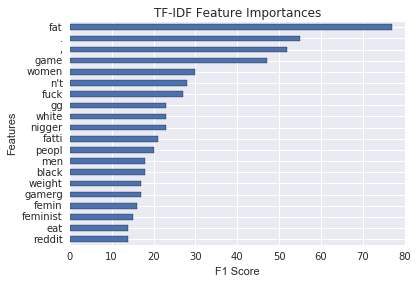

In [21]:
dfscore[:20].plot(kind='barh',legend=False,)
plt.xlabel("F1 Score")
plt.ylabel("Features")
plt.title("TF-IDF Feature Importances")
plt.gca().invert_yaxis()
plt.savefig('Feature_Importance.jpg')

In [66]:
# dfscore.to_csv(fscorepath)

In [13]:
dresults.head()

,Unnamed: 0,Unnamed: 0.1,tweet_text,label,xgboost_predict
0,0,12168,I love how Jayden acts like we have no right t...,1,0.409886
1,1,13497,I been POPPIN since kindergarten nigga you a l...,1,0.509634
2,2,10058,Like a real life mean person could make you cr...,0,0.329897
3,3,4559,Which fags are getting down and tributing Xmas...,1,0.527562
4,4,5514,From last night...my thoughts on J-Up and what...,0,0.339007


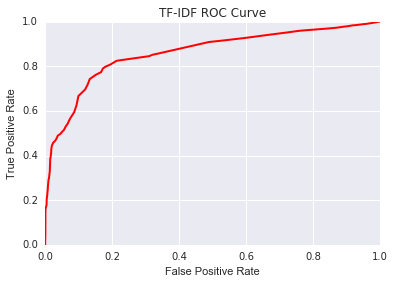

In [22]:
labels = dresults['label'].values
TPR = []
FPR = []

for i in xrange(101):
    threshold = i/100.0
    predict = dresults['xgboost_predict'].values >= threshold
    
    TP = sum(predict+labels==2)
    TN = sum(predict+labels==0)
    FP = sum(predict-labels==1)
    FN = sum(predict-labels==-1)
    
#     print "accuracy: {} | threshold {}".format((TP+TN)/float(len(labels)),threshold)
    
    TPR.append(TP/float(TP+FN))
    FPR.append(FP/float(FP+TN))
    
plt.plot(FPR,TPR,'r',linewidth=2)
plt.xlabel('False Positive Rate')
plt.xlim([0,1])
plt.ylabel('True Positive Rate')
plt.ylim([0,1])
titlestr = "TF-IDF ROC Curve".format(np.trapz(TPR[::-1],x=FPR[::-1]))
plt.title(titlestr)  
plt.savefig('TFIDFROC.jpg')